Imports:

In [1]:
from train_for_real import *

c:\Users\mariusz\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mariusz\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\mariusz\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_5m_224 i

In [2]:
from finetuneSAM.cfg import parse_args
#Fine-Tune Sam
args =  parse_args()


# setting if_mask_decoder_adapter = True puts adapters inside 2-way transformer blocks
# this does not change the number of decoder 2-way transformer blocks (def = 2)
# decoder_adapt_depth denotes how many of the two 2-way transformer blocks are adapted


# setting if_encoder_adapter = True puts adapters inside TinyViTBlocks in the encoder
# this does not change the number of encoder TinyViTBlocks (def = 4)
# encoder_adapt_depth (e.g. [1,2]) denotes how deep blocks will be adapted

args.finetune_type = "vanilla"
#args.finetune_type = "adapter"# "vanilla"
#args.if_mask_decoder_adapter = True
#args.image_size = 512
#args.decoder_adapt_depth = 1
args.num_cls = 2


sam = load_model(args)




c:\SamPeft\finetuneSAM\models\sam\build_sam.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [43]:

org_data = load_data()
sammy = Sammy(sam)



In [ ]:
sammy.set_image(org_data[0])

['image', 'mask', 't_points', 'bg_points']

In [5]:
features = sammy.encode_img()

In [ ]:
sparse_embeddings, dense_embeddings = sammy.encode_promts(org_data['t_points'][0], org_data['bg_points'][0])

In [7]:
masks, iou_predictions, low_res_masks = sammy.decode_features(features, sparse_embeddings, dense_embeddings)
iou_predictions

tensor([[-0.1588, -0.0564]], device='cuda:0', grad_fn=<SliceBackward0>)

In [8]:
print(masks.shape)

torch.Size([1, 2, 512, 512])


In [9]:
#show image masks
from PIL import Image
mask1 = np.array(masks[0][0].detach().cpu())
mask2 = np.array(masks[0][1].detach().cpu())


In [10]:
Image.fromarray(mask1*255).show()
Image.fromarray(mask2*255).show()

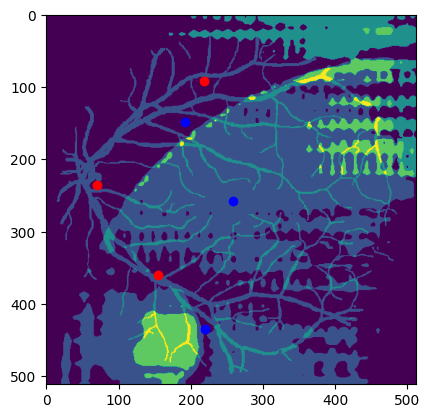

In [ ]:
from matplotlib import pyplot as plt
ts = org_data['t_points'][0]
bgs = org_data['bg_points'][0]
tru = org_data['mask'][0]
tru = np.where(tru>0, 1, 0)
pred_t = np.where(mask1>0.5, 1, 0)
pred_b = np.where(mask2>0.5, 1, 0)
tru =  tru + pred_t + pred_b*2

plt.imshow(tru)
plt.scatter(ts[:,0], ts[:,1], c='r')
plt.scatter(bgs[:,0], bgs[:,1], c='b')
plt.show()

In [44]:
CUDA_LAUNCH_BLOCKING=1
from finetuneSAM.utils.dsc import dice_coeff_multi_class

sam = sam
data = org_data.copy()
train_points = len(data['image'])
checkpoints_path = 'checkpoints'


val_percentage = 0.50
val_points = int(train_points*val_percentage)
train_points = train_points - val_points
print('Train points:',train_points)

val_data = {"image":[],"mask":[],"t_points":[],"bg_points":[]}
for i in range(val_points):
    rnd_indx = np.random.randint(0,len(data["image"])-1)
    val_data["image"].append(data["image"].pop(rnd_indx))
    val_data["mask"].append(data["mask"].pop(rnd_indx))
    val_data["t_points"].append(data["t_points"].pop(rnd_indx))
    val_data["bg_points"].append(data["bg_points"].pop(rnd_indx))
    

if args.finetune_type == 'adapter':
    for n, value in sam.named_parameters():
        if "Adapter" not in n: # only update parameters in adapter
            value.requires_grad = False
    print('if update encoder:',args.if_update_encoder)
    print('if image encoder adapter:',args.if_encoder_adapter)
    print('if mask decoder adapter:',args.if_mask_decoder_adapter)
    if args.if_encoder_adapter:
        print('added adapter layers:',args.encoder_adapter_depths)
    
# elif args.finetune_type == 'vanilla' and args.if_update_encoder==False:   
#     print('if update encoder:',args.if_update_encoder)
#     for n, value in sam.image_encoder.named_parameters():
#         value.requires_grad = False
# elif args.finetune_type == 'lora':
#     print('if update encoder:',args.if_update_encoder)
#     print('if image encoder lora:',args.if_encoder_lora_layer)
#     print('if mask decoder lora:',args.if_decoder_lora_layer)
#     sam = LoRA_Sam(args,sam,r=4).sam
# sam.to('cuda')
b_lr = args.lr
epochs = 6
    
optimizer = optim.AdamW(sam.parameters(), lr=b_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #learning rate decay
criterion1 = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, to_onehot_y=True,reduction='mean')
criterion2 = nn.CrossEntropyLoss()
iter_num = 0
max_iterations = epochs * train_points
writer = SummaryWriter(checkpoints_path + '/log')

pbar = tqdm(range(epochs))
val_largest_dsc = 0
last_update_epoch = 0
print('Start training')
for epoch in pbar:
    print('Epoch num {}'.format(epoch))
    sam.train()
    train_loss = 0
    for i in range(train_points):
        
        imgs = data['image'][i]
        msks = data['mask'][i]
        sammy.set_image(imgs)

        if args.if_update_encoder:
            #img_emb = sam.image_encoder(imgs)
            img_emb = sammy.encode_img()
        else:
            with torch.no_grad():
                #img_emb = sam.image_encoder(imgs)
                img_emb = sammy.encode_img()
        
        sparse_emb, dense_emb = sammy.encode_promts(data['t_points'][i], data['bg_points'][i])
        pred, _,_ = sammy.decode_features(img_emb, sparse_emb, dense_emb)
        #loss_dice = criterion1(pred,msks.float())
        x = torch.tensor([msks]).long().cuda() 
        loss_ce = criterion2(pred,torch.tensor([msks]).long().cuda())
        loss =  loss_ce
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
        if args.if_warmup and iter_num < args.warmup_period:
            lr_ = args.lr * ((iter_num + 1) / args.warmup_period)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_

        else:
            if args.if_warmup:
                shift_iter = iter_num - args.warmup_period
                assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
                lr_ = args.lr * (1.0 - shift_iter / max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_
            else:
                lr_ = args.lr

        train_loss += loss.item()
        iter_num+=1
        writer.add_scalar('info/lr', lr_, iter_num)
        writer.add_scalar('info/total_loss', loss, iter_num)
        writer.add_scalar('info/loss_ce', loss_ce, iter_num)
        #writer.add_scalar('info/loss_dice', loss_dice, iter_num)

    train_loss /= (i+1)
    pbar.set_description('Epoch num {}| train loss {} \n'.format(epoch,train_loss))

    if epoch%2==0:
        
        eval_loss=0
        dsc = 0
        sam.eval()
        with torch.no_grad():
            for i in range(val_points):
                print('Validation point num {}'.format(i))
                imgs = val_data['image'][i]
                msks = val_data['mask'][i]
                sammy.set_image(imgs)

                        #img_emb = sam.image_encoder(imgs)
                img_emb = sammy.encode_img()
                
                sparse_emb, dense_emb = sammy.encode_promts(data['t_points'][i], data['bg_points'][i])
                
                pred, _,_ = sammy.decode_features(img_emb, sparse_emb, dense_emb)
                
                #loss_dice = criterion1(pred,msks.float())
                x = torch.tensor([msks]).long().cuda() 
                loss = criterion2(pred,torch.tensor([msks]).long().cuda())
                
                eval_loss +=loss.item()
                dsc_batch = dice_coeff_multi_class(pred.argmax(dim=1).cpu(), torch.squeeze(msks.long(),1).cpu().long(),args.num_cls)
                dsc+=dsc_batch
                print("HELOOOOOOOOOOOOOOOOOOOOOOOOOOOOO")
                print(dsc_batch)

            eval_loss /= (i+1)
            dsc /= (i+1)
            
            writer.add_scalar('eval/loss', eval_loss, epoch)
            writer.add_scalar('eval/dice', dsc, epoch)
            
            print('Eval Epoch num {} | val loss {} | dsc {} \n'.format(epoch,eval_loss,dsc))
            if dsc>val_largest_dsc:
                val_largest_dsc = dsc
                last_update_epoch = epoch
                print('largest DSC now: {}'.format(dsc))
                torch.save(sam.state_dict(),checkpoints_path + '/checkpoint_best.pth')
            elif (epoch-last_update_epoch)>20:
                # the network haven't been updated for 20 epochs
                print('Training finished###########')
                break
writer.close()

Train points: 1


  0%|          | 0/6 [00:00<?, ?it/s]

Start training
Epoch num 0


Epoch num 0| train loss 0.29862672090530396 
:   0%|          | 0/6 [00:00<?, ?it/s]

Validation point num 0


Epoch num 0| train loss 0.29862672090530396 
:   0%|          | 0/6 [00:01<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'long'

In [13]:
x.shape
#loss_ce = criterion2(pred,x)
# loss_ce 

torch.Size([1, 512, 512])

In [14]:
pred.shape

torch.Size([1, 2, 512, 512])

In [15]:
pred.dtype

torch.float32

In [16]:
p = np.random.rand(1,512,512)
p = p.astype(np.float32)
print(p.dtype)
t = np.ones((1,512,512))
p = torch.tensor(p).cuda()
t = torch.tensor(t).cuda()
print(p.shape, pred.shape)
print(t.shape, x.shape)
l = criterion2(p,t)
l

float32
torch.Size([1, 512, 512]) torch.Size([1, 2, 512, 512])
torch.Size([1, 512, 512]) torch.Size([1, 512, 512])


tensor(3215.0963, device='cuda:0', dtype=torch.float64)

In [17]:
x = x.detach().cpu()
pred = pred.detach().cpu()
pred


tensor([[[[-1.2188e+01, -1.2188e+01, -1.2188e+01,  ..., -1.6595e+01,
           -1.6604e+01, -1.6608e+01],
          [-1.2188e+01, -1.2188e+01, -1.2188e+01,  ..., -1.6595e+01,
           -1.6604e+01, -1.6608e+01],
          [-1.2188e+01, -1.2188e+01, -1.2188e+01,  ..., -1.6595e+01,
           -1.6604e+01, -1.6608e+01],
          ...,
          [-1.6844e+01, -1.6844e+01, -1.6844e+01,  ..., -7.8864e+00,
           -8.2535e+00, -8.4371e+00],
          [-1.6180e+01, -1.6180e+01, -1.6180e+01,  ..., -7.3624e+00,
           -7.6740e+00, -7.8298e+00],
          [-1.5847e+01, -1.5847e+01, -1.5847e+01,  ..., -7.1004e+00,
           -7.3843e+00, -7.5262e+00]],

         [[-5.4991e+00, -5.4991e+00, -5.4991e+00,  ..., -2.6297e+00,
           -2.7092e+00, -2.7490e+00],
          [-5.4991e+00, -5.4991e+00, -5.4991e+00,  ..., -2.6297e+00,
           -2.7092e+00, -2.7490e+00],
          [-5.4991e+00, -5.4991e+00, -5.4991e+00,  ..., -2.6297e+00,
           -2.7092e+00, -2.7490e+00],
          ...,
     

In [18]:
pred.shape

torch.Size([1, 2, 512, 512])

In [19]:
np.unique(pred)

array([-61.75311 , -61.716473, -60.852818, ...,  25.685675,  25.872208,
        25.891598], dtype=float32)

In [20]:
# WORKS ?!
t = t.detach().cpu()
l = criterion2(pred,t.long())
l

tensor(0.6651)

In [21]:
mm = np.where(msks>0, 1, 0)
mm = torch.tensor([mm]).long().detach().cpu()
mm.dtype

torch.int64

In [22]:
criterion2(pred,mm)

tensor(8.5072)

In [23]:
criterion2(pred.cuda(),mm.cuda())

tensor(8.5072, device='cuda:0')

In [24]:
loss_ce

tensor(8.5072, device='cuda:0', grad_fn=<NllLoss2DBackward0>)